## Get report folders from Github
Upload report files, get data from github repository, just specify experiment number to get files from, if you want to upload files manually skip these two cells or set the filed to 0

In [1]:
# set the experiment number to take files from
# set 0 to skip and upload files manually
experiment_number = 4

In [2]:
# Import the data
import requests
import pandas as pd
import os

if experiment_number > 0:
  # get the reports from GitHub
  folder_path = f"exp_{experiment_number}"
  repo_owner = "asmeta"
  repo_name = "asmeta"
  branch_name = "isaac"
  folder_path = f"code/experimental/asmeta.evotest/asmeta.evotest.experiments/data/exp_{experiment_number}"

  # GitHub URL API
  api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch_name}"

  # Github API
  response = requests.get(api_url)
  subfolders = response.json()

  # Loop through each subfolder
  for subfolder in subfolders:
      if subfolder["type"] == "dir":
          subfolder_url = subfolder["url"]
          response = requests.get(subfolder_url)
          files = response.json()

          # Download CSV files from the subfolder
          for file in files:
              if file["name"].endswith(".csv"):
                  file_url = file["download_url"]

                  # Create the directory if it doesn't exist
                  file_path = os.path.join("/content/", subfolder["name"], file["name"])  # Preserve subfolder structure
                  os.makedirs(os.path.dirname(file_path), exist_ok=True)

                  with open(file_path, "wb") as f:
                      f.write(requests.get(file_url).content)

## Build the benchmark file

In [3]:
import os
import pandas as pd
import re

# Compares benchmarks.csv files in subfolders and saves a consolidated file.

first_benchmark = None  # To store the first benchmark file for comparison
all_benchmarks_same = True  # Flag to track if all benchmarks are the same

for subdir, dirs, files in os.walk("/content/"):
    # Skip subfolders that don't match the numeric pattern
    if not re.fullmatch(r'\d+', os.path.basename(subdir)):
        continue
    benchmark_path = os.path.join(subdir, 'benchmark.csv')
    if os.path.exists(benchmark_path):
        # Read the benchmark file
        current_benchmark = pd.read_csv(benchmark_path)

        # Compare with the first benchmark file
        if first_benchmark is None:
            first_benchmark = current_benchmark
        elif not current_benchmark.equals(first_benchmark):
            all_benchmarks_same = False
            print(f"Warning: Benchmark file in '{subdir}' is different.")

# Save the benchmark file to the root directory if all are the same
if all_benchmarks_same and first_benchmark is not None:
    first_benchmark.to_csv(os.path.join("/content/", 'benchmark.csv'), index=False)
    print("Benchmarks are the same. Saved to '/content/benchmark.csv'.")
else:
    print("Benchmarks are different. No consolidated file saved.")

Benchmarks are the same. Saved to '/content/benchmark.csv'.


## Build the aggragate report file

In [4]:
import pandas as pd
import re

def add_experiment_data_to_benchmark(benchmark_df, experiment_df, experiment_number):
    """
    Adds experiment data to the benchmark dataframe.

    Args:
    benchmark_df: The benchmark dataframe.
    experiment_df: The experiment dataframe.
    experiment_number: The experiment number.

    Returns:
    The updated benchmark dataframe.
    """
    # create new columns for the experiment
    covered_conditional_col = f"covered_conditional_{experiment_number}"
    covered_update_col = f"covered_update_{experiment_number}"
    benchmark_df[covered_conditional_col] = 0.0
    benchmark_df[covered_update_col] = 0

    for index, row in benchmark_df.iterrows():
        # Find the corresponding row in the experiment dataframe
        experiment_row = experiment_df[
            (experiment_df["asm_name"] == row["asm_name"]) &
            (experiment_df["rule_signature"].str.lower().replace(r"\(.*\)", "", regex=True) ==
             re.sub(r"\(.*\)", "", row["rule_signature"]).lower())
        ]
        # if the row is found, update the benchmark columns
        if not experiment_row.empty:
            benchmark_df.loc[index, covered_conditional_col] = (
                (experiment_row["covered_true_conditional_rules"].values[0] +
                experiment_row["covered_false_conditional_rules"].values[0]) / 2
            )
            benchmark_df.loc[index, covered_update_col] = experiment_row["covered_update_rules"].values[0]
    return benchmark_df


def build_report(report_file_name, root_dir='/content/'):
    experiments = 0 # number of experiments
    benchmark_df = pd.read_csv(os.path.join(root_dir, 'benchmark.csv'))

    for subdir, dirs, files in os.walk(root_dir):
        # Skip subfolders that don't match the numeric pattern
        if not re.fullmatch(r'\d+', os.path.basename(subdir)):
            continue

        # Find the specific report CSV file in the subfolder
        report_file_path = os.path.join(subdir, report_file_name)
        if os.path.exists(report_file_path):
            df = pd.read_csv(report_file_path)
            experiments += 1
            benchmark_df = add_experiment_data_to_benchmark(benchmark_df, df, experiments)
    return benchmark_df


In [5]:
evoavalla_df = build_report('report_evoavalla.csv')
print("EvoAvalla report")
display(evoavalla_df)

random_df = build_report('report_random.csv')
print("Random report")
display(random_df)

atgt_df = build_report('report_atgt.csv')
print("Atgt report")
display(atgt_df)

EvoAvalla report


,asm_name,rule_signature,tot_conditional_rules,tot_update_rules,covered_conditional_1,covered_update_1,covered_conditional_2,covered_update_2,covered_conditional_3,covered_update_3,...,covered_conditional_6,covered_update_6,covered_conditional_7,covered_update_7,covered_conditional_8,covered_update_8,covered_conditional_9,covered_update_9,covered_conditional_10,covered_update_10
0,Ascensore,r_Main,6,7,5.0,7,5.0,7,5.0,7,...,5.0,7,5.0,7,5.0,7,5.0,7,4.5,7
1,ATM3v2,r_subtractFrom,0,1,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2,ATM3v2,r_goOutOfService,0,1,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
3,ATM3v2,r_insertcard,2,2,1.0,2,0.0,0,1.5,2,...,0.0,0,1.5,2,0.0,0,0.0,0,1.5,2
4,ATM3v2,r_enterPin,2,3,0.5,0,0.0,0,1.5,1,...,0.0,0,1.5,1,0.0,0,0.0,0,1.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,TrafficLightv2,r_red,1,3,1.0,3,1.0,3,1.0,3,...,1.0,3,1.0,3,1.0,3,1.0,3,1.0,3
129,TrafficLightv2,r_green,2,5,2.0,5,2.0,5,2.0,5,...,2.0,5,2.0,5,2.0,5,2.0,5,2.0,5
130,TrafficLightv2,r_yellow,1,3,1.0,3,1.0,3,1.0,3,...,1.0,3,1.0,3,1.0,3,1.0,3,1.0,3
131,TrafficLightv2,r_pending,1,3,1.0,3,1.0,3,1.0,3,...,1.0,3,1.0,3,1.0,3,1.0,3,1.0,3


Random report


,asm_name,rule_signature,tot_conditional_rules,tot_update_rules,covered_conditional_1,covered_update_1,covered_conditional_2,covered_update_2,covered_conditional_3,covered_update_3,...,covered_conditional_6,covered_update_6,covered_conditional_7,covered_update_7,covered_conditional_8,covered_update_8,covered_conditional_9,covered_update_9,covered_conditional_10,covered_update_10
0,Ascensore,r_Main,6,7,3.5,4,4.5,5,3.5,4,...,4.5,5,3.5,5,5.0,7,5.0,7,4.0,6
1,ATM3v2,r_subtractFrom,0,1,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2,ATM3v2,r_goOutOfService,0,1,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
3,ATM3v2,r_insertcard,2,2,1.5,2,1.5,2,1.5,2,...,1.5,2,1.5,2,1.5,2,1.5,2,1.5,2
4,ATM3v2,r_enterPin,2,3,1.5,1,1.5,1,1.5,1,...,1.5,1,1.5,1,1.5,1,1.5,1,1.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,TrafficLightv2,r_red,1,3,1.0,3,1.0,3,1.0,3,...,1.0,3,1.0,3,1.0,3,1.0,3,1.0,3
129,TrafficLightv2,r_green,2,5,0.5,2,1.5,3,1.5,3,...,1.5,3,1.5,3,1.5,3,1.5,3,1.5,3
130,TrafficLightv2,r_yellow,1,3,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
131,TrafficLightv2,r_pending,1,3,1.0,3,1.0,3,1.0,3,...,1.0,3,1.0,3,1.0,3,1.0,3,1.0,3


Atgt report


,asm_name,rule_signature,tot_conditional_rules,tot_update_rules,covered_conditional_1,covered_update_1,covered_conditional_2,covered_update_2,covered_conditional_3,covered_update_3,...,covered_conditional_6,covered_update_6,covered_conditional_7,covered_update_7,covered_conditional_8,covered_update_8,covered_conditional_9,covered_update_9,covered_conditional_10,covered_update_10
0,Ascensore,r_Main,6,7,5.0,7,5.0,7,5.0,7,...,5.0,7,5.0,7,5.0,7,5.0,7,5.0,7
1,ATM3v2,r_subtractFrom,0,1,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2,ATM3v2,r_goOutOfService,0,1,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
3,ATM3v2,r_insertcard,2,2,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
4,ATM3v2,r_enterPin,2,3,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,TrafficLightv2,r_red,1,3,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
129,TrafficLightv2,r_green,2,5,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
130,TrafficLightv2,r_yellow,1,3,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
131,TrafficLightv2,r_pending,1,3,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


## Generate the box plot

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_coverage(row, experiment_number):
    """Calculate the coverage for a specific experiment in percentage."""
    covered_conditional = row[f"covered_conditional_{experiment_number}"]
    covered_update = row[f"covered_update_{experiment_number}"]
    tot_conditional = row["tot_conditional_rules"]
    tot_update = row["tot_update_rules"]

    # Handles division by zero
    if (tot_conditional + tot_update) == 0:
        return 0
    else:
        coverage = (covered_conditional + covered_update) / (tot_conditional + tot_update) *100
        return coverage

def generate_coverage_plot(df, title):
    """Generate a box plot of the coverage for a data frame."""
    coverage_data = []

    for experiment_number in range(1, 11):  # Iteration for each experiment (from 1 to 10)
        for asm_name in df["asm_name"].unique():  # Iteration for each unique asm_name
            # Filter the original DataFrame for specific asm_name
            asm_df = df[df["asm_name"] == asm_name]

            # Calculate the average coverage for the current experiment and asm_name
            total_covered_conditional = asm_df[f"covered_conditional_{experiment_number}"].sum()
            total_covered_update = asm_df[f"covered_update_{experiment_number}"].sum()
            total_conditional = asm_df["tot_conditional_rules"].sum()
            total_update = asm_df["tot_update_rules"].sum()

            # Handles division by zero
            if (total_conditional + total_update) == 0:
                coverage = 0
            else:
                coverage = (total_covered_conditional + total_covered_update) / (total_conditional + total_update) *100

            # Add coverage data to the new DataFrame
            coverage_data.append([asm_name, experiment_number, coverage])

    coverage_df = pd.DataFrame(coverage_data, columns=["asm_name", "experiment", "coverage"])

    # Create box plot graph
    ax = sns.boxplot(x="asm_name", y="coverage", data=coverage_df, color="C0")
    plt.title(title)
    plt.xlabel("asm_name")
    plt.ylabel("Coverage (%)")
    plt.xticks(rotation=45, ha="right")

    # Add the mean above each box plot
    for i, asm_name in enumerate(coverage_df["asm_name"].unique()):
        mean_coverage = coverage_df[coverage_df["asm_name"] == asm_name]["coverage"].mean()
        # Calculate the vertical position of the average text
        box_top = coverage_df[coverage_df["asm_name"] == asm_name]["coverage"].max()  # Find the maximum value of the box plot
        text_y = box_top + 1  # Place the text 1 unit above the maximum value of the box plot
        ax.text(i, text_y, f"{mean_coverage:.0f}%", ha='center', va='bottom')

    plt.tight_layout()

def generate_general_plot(df1, df2, df3):
    """Genera un grafico generale con tre sottografici."""
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharey=True)
    # Generate subgraphs
    plt.sca(axes[0])
    generate_coverage_plot(df1, "Coverage distribution EvoAvalla")
    plt.sca(axes[1])
    generate_coverage_plot(df2, "Coverage distribution Random")
    plt.sca(axes[2])
    generate_coverage_plot(df3, "Coverage distribution ATGT")

    plt.tight_layout()
    plt.show()


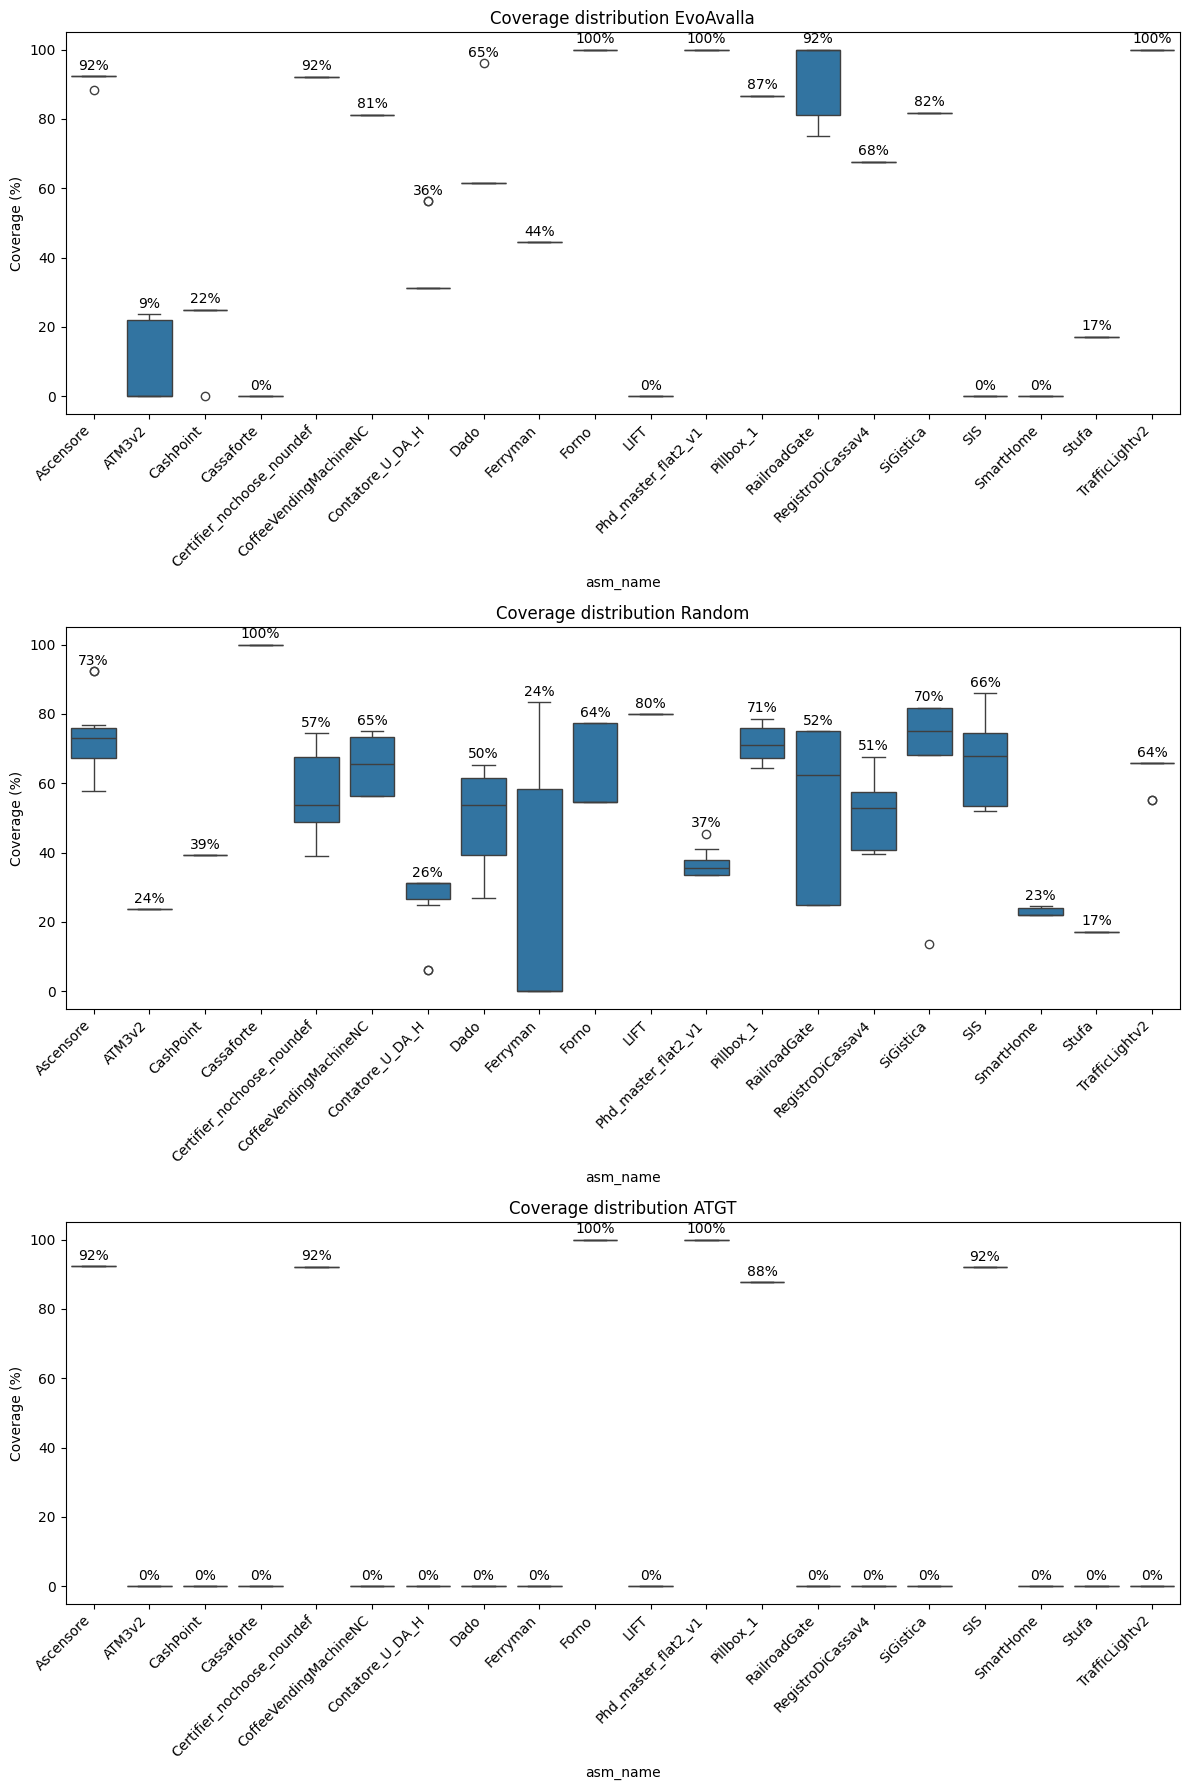

In [7]:
generate_general_plot(evoavalla_df, random_df, atgt_df)